# Transfer Learning Using PyTorch Lightning ⚡️

## Setting up PyTorch Lightning

For this tutorial, we need PyTorch Lightning

In [1]:
!nvidia-smi

Wed May 10 16:26:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          Off  | 00000000:01:00.0 Off |                  Off |
|  0%   53C    P0    61W / 150W |   3195MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Завершить все процессы, использующие ГПУ в нашей ОС
# !fuser -k /dev/nvidia[0]

In [1]:
import os

In [2]:
# сменим директорию на корневой каталог проекта
project_dir = os.path.split(os.getcwd())[0]
os.chdir(project_dir)

In [3]:
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision.models as models
from PIL import Image
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F

from src.models import DatasetClass
from src.models import EmotionNetTrain


## Загрузка данных

In [4]:
path2datset = 'data/processed/RAVDESS_frames_set'
rel_path2_train = 'train.csv'
rel_path2_test = 'test.csv'

In [5]:
df_train = DatasetClass.read_and_preprocess_annotation(path2datset, rel_path2_train)
df_test = DatasetClass.read_and_preprocess_annotation(path2datset, rel_path2_test)

# число различных эмоций в датасете
emotion_num = DatasetClass.df_get_classes(df_train)

## Train your Model 🏋️‍♂️

### Вначале определим оптимальный learning rate для нашей модели!

In [6]:
dm = DatasetClass.ClassificationDataModule(df_train,
                                           df_test,
                                           df_test,
                                           img_path_col='image_path',
                                           target_col='emotion_class',
                                           rescale_size=(224, 224),
                                           batch_size=64,
                                           num_workers=12)


# Небольшая проверка работы загрузчика данных

In [7]:
data_loader = dm.train_dataloader()
image , label = next(iter(data_loader))

In [8]:
image.shape

torch.Size([64, 3, 224, 224])

In [9]:
label

tensor([1, 5, 4, 7, 1, 4, 7, 4, 6, 3, 4, 3, 1, 2, 3, 4, 3, 2, 0, 2, 3, 1, 6, 4,
        4, 1, 3, 7, 4, 2, 5, 3, 7, 1, 4, 4, 1, 2, 4, 4, 5, 7, 3, 0, 4, 3, 5, 5,
        2, 2, 6, 2, 6, 2, 2, 6, 7, 4, 1, 3, 5, 3, 1, 1])

# Обучение модели

In [10]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

# создадим обратный вызов на раннюю остановку обучения
early_stop_callback = EarlyStopping(monitor="val_f1", patience=10, verbose=False, mode="max")

# создадим обратный вызов на сохранение чекпоинта модели,
# по интересующей нас метрике
# saves top-K checkpoints based on "val_loss" metric
checkpoint_callback_val_loss = ModelCheckpoint(
    save_top_k=5,
    monitor="val_loss",
    mode="min",
    filename="check_point-{epoch:02d}-{val_loss:.2f}",
)

# saves last-K checkpoints based on "global_step" metric
# make sure you log it inside your LightningModule
checkpoint_callback_last_step = ModelCheckpoint(
    save_top_k=1,
    monitor="train_step",
    mode="max",
    filename="check_point-{epoch:02d}-{train_step}",
)


In [11]:
# начинаем обучение модели
opt_lr = 1 * 10**-4
model = EmotionNetTrain.LitModel((3, 224, 224),
                                 emotion_num,
                                 fc_only=True,
                                 learning_rate=opt_lr)

# добавляем список обратных вызовов в параметр callbacks
trainer = pl.Trainer(accelerator="gpu",
                     callbacks=[early_stop_callback,
                                checkpoint_callback_val_loss,
                                checkpoint_callback_last_step],
                     max_epochs=10,
                     log_every_n_steps=10)


/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(model, dm)

/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params
-------------------------------------------------
0 | neural_net | ResNet            | 23.5 M
1 | metric     | MulticlassF1Score | 0     
-------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.098    Total estimated model pa

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('train_step', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# Загружаем модель из чекпоинта

In [27]:
checkpoint_path = "models/version_1/checkpoints/check_point-epoch=03-val_loss=2.15.ckpt"
model = model.load_from_checkpoint(checkpoint_path)

/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Протестируем полученную модель

In [15]:
# можем проверить на val части датасета
trainer.validate(model, dm)

You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │    0.45323309302330017    │
│         val_loss          │    2.1491947174072266     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 2.1491947174072266, 'val_f1': 0.45323309302330017}]

## Загрузим желаемый чекпоинт

In [16]:
# disable randomness, dropout, etc...
model.eval();

## Сделаем предсказание

### Сделаем предсказание на val

Проверим, что функции предсказания работаю корректно.
И что мы получаем тот же самый результат по метрике MSE, что и раньше.

In [17]:
# predict with the model
y_preds_batchs = trainer.predict(model, dm.val_dataloader())


You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 1it [00:00, ?it/s]

In [18]:
y_preds = []
for y_preds_batch in y_preds_batchs:
    y_preds.extend(y_preds_batch)

In [19]:
y_true = df_test['emotion_class'].values
y_true.size

3325

In [20]:
from sklearn.metrics import f1_score

# Оценим нашу модель на валидационной выборке:
print(f"F1 = {f1_score(y_true, y_preds, average='micro')}")

F1 = 0.45323308270676693


In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_preds, normalize='true')

In [22]:
cm = np.round((cm * 100), 2)

In [23]:
class_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

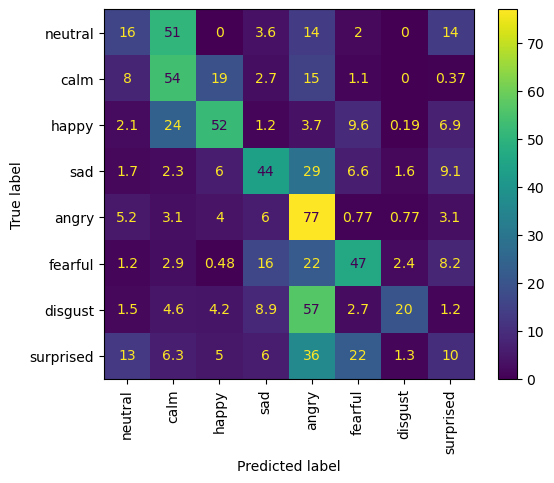

In [24]:
ConfusionMatrixDisplay(cm, display_labels=class_labels).plot(xticks_rotation='vertical')

In [25]:
import sklearn

print(sklearn.__version__)

1.2.2


# Сериализуем модель

In [28]:
model = model.load_from_checkpoint(checkpoint_path)

/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
model.dim

(3, 224, 224)

In [31]:
torch.save(model.neural_net, 'models/my_model.pth')